Monitorar o fairness

In [53]:
import pandas as pd
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Carregar modelo e vetor ja treinados

In [54]:
modelo_path = "../model.joblib"
vectorizer_path = "../vectorizer.joblib"
dados_path = "../data/tweets_limpo.csv"

if not (os.path.exists(modelo_path)) and not (os.path.exists(vectorizer_path)):
    raise FileNotFoundError("Modelo ou vetor não encontrados. Certifique-se de que foram salvos corretamente.")

model = joblib.load(modelo_path)
vectorizer = joblib.load(vectorizer_path)
df = pd.read_csv(dados_path)
display(df.head())

,text,label,text_lenght
0,O produto e bom.,positivo,16
1,O produto e ruim.,negativo,17
2,Entrega rapida.,positivo,15
3,Produto chegou danificado.,negativo,26
4,Muito bom!,positivo,10


Monitoramento

In [55]:
novos_textos = [
    'Muito ruim.',
    'Nao gostei.',
    'Muito bom.',
    'Gostei muito.'
]

novos_df = pd.DataFrame({'text': novos_textos})

Vetorizar e predicao

In [56]:
novos_vetores = vectorizer.transform(novos_df['text'])
novos_preds = model.predict(novos_vetores)
novos_df['predicao'] = novos_preds
print(novos_df)

            text  predicao
0    Muito ruim.  negativo
1    Nao gostei.  positivo
2     Muito bom.  positivo
3  Gostei muito.  positivo


Porcentagem de cada classe

In [57]:
class_dist = novos_df['predicao'].value_counts(normalize=True)
print("Porcentagem de cada classe:")
print(class_dist)

Porcentagem de cada classe:
predicao
positivo    0.75
negativo    0.25
Name: proportion, dtype: float64


Fairness - Vieses

In [58]:
df['text_len'] = df['text'].apply(len)
df['len_category'] = pd.cut(df['text_len'], bins=[0, 40, 100, 200, 1000], labels=['curto', 'medio', 'grande', 'textao'])
display(df['len_category'])

0     curto
1     curto
2     curto
3     curto
4     curto
5     curto
6     curto
7     curto
8     curto
9     curto
10    curto
11    medio
12    curto
13    curto
14    curto
15    curto
16    curto
Name: len_category, dtype: category
Categories (4, object): ['curto' < 'medio' < 'grande' < 'textao']

Predicoes de validacao

In [59]:
vetores = vectorizer.transform(df['text'])
df['pred'] = model.predict(vetores)
display(df['pred'])

0     positivo
1     negativo
2     positivo
3     negativo
4     positivo
5     negativo
6     positivo
7     negativo
8     positivo
9     negativo
10    positivo
11    negativo
12    positivo
13    negativo
14    positivo
15    positivo
16    negativo
Name: pred, dtype: object

Avaliacao da acuracia

In [60]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        acuracia = (subset['label'] == subset['pred']).mean()
        print(f"Acuracia {cat}: {acuracia:.2f} (N={len(subset)})")

Acuracia curto: 0.94 (N=16)
Acuracia medio: 1.00 (N=1)


Desafio fairness

Matriz de confusao para textos curto:
[[7 1]
 [0 8]]


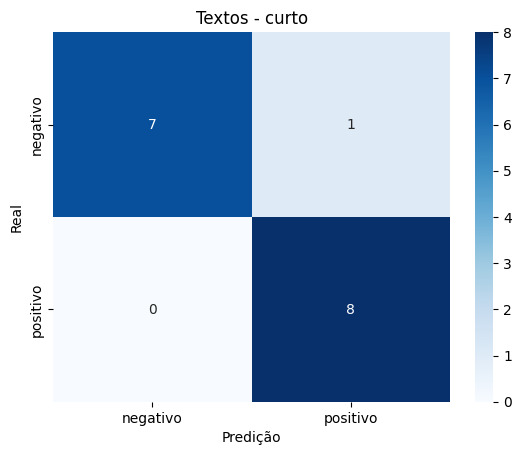

Matriz de confusao para textos medio:


c:\Users\Douglas Sousa\Documents\Pipeline_ESBD3\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Douglas Sousa\Documents\Pipeline_ESBD3\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


[[1]]


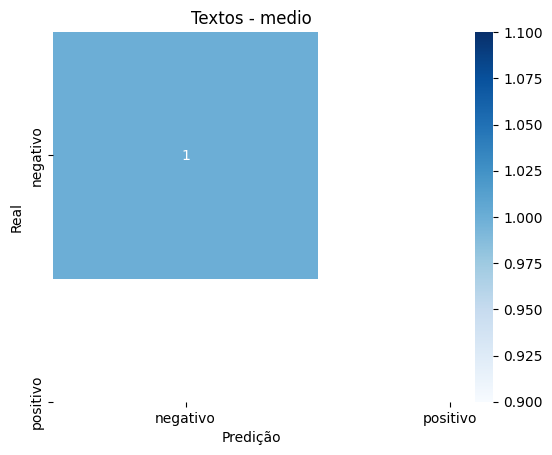

In [61]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        print(f"Matriz de confusao para textos {cat}:")
        print(confusion_matrix(subset['label'], subset['pred']))
        sns.heatmap(confusion_matrix(subset['label'], subset['pred']), 
                    annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['negativo', 'positivo'], 
                    yticklabels=['negativo', 'positivo']
                    )
        plt.title(f'Textos - {cat}')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()